In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, BatchNormalization, Activation, Input
from tensorflow.keras.optimizers import Adam
# Importing necessary libraries for data processing, machine learning, and visualization
import pandas as pd
import json
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

2025-07-23 18:21:48.208471: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753294908.447622      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753294908.514485      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Loading and resampling time-series datasets from April 2014, categorized by metric type
datasets = {
    'ec2_cpu_utilization_ac20cd': pd.read_csv('/kaggle/input/nab/realAWSCloudwatch/realAWSCloudwatch/ec2_cpu_utilization_ac20cd.csv'),
    'ec2_cpu_utilization_c6585a': pd.read_csv('/kaggle/input/nab/realAWSCloudwatch/realAWSCloudwatch/ec2_cpu_utilization_c6585a.csv'),
    'ec2_cpu_utilization_77c1ca': pd.read_csv('/kaggle/input/nab/realAWSCloudwatch/realAWSCloudwatch/ec2_cpu_utilization_77c1ca.csv'),
    'ec2_cpu_utilization_825cc2': pd.read_csv('/kaggle/input/nab/realAWSCloudwatch/realAWSCloudwatch/ec2_cpu_utilization_825cc2.csv'),
    'rds_cpu_utilization_e47b3b': pd.read_csv('/kaggle/input/nab/realAWSCloudwatch/realAWSCloudwatch/rds_cpu_utilization_e47b3b.csv'),
    'ec2_disk_write_bytes_c0d644': pd.read_csv('/kaggle/input/nab/realAWSCloudwatch/realAWSCloudwatch/ec2_disk_write_bytes_c0d644.csv'),
    'ec2_network_in_257a54': pd.read_csv('/kaggle/input/nab/realAWSCloudwatch/realAWSCloudwatch/ec2_network_in_257a54.csv')
}

# Load anomaly labels
with open('/kaggle/input/nab-combined-labels/combined_labels.json', 'r') as f:
    labels = json.load(f)

# Convert timestamps to datetime, set as index, and resample to 5-minute intervals
anomalies = {}
for key, df in datasets.items():
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df.set_index('timestamp', inplace=True)
    datasets[key] = df.resample('5min').mean().interpolate()
    # Load corresponding anomaly labels
    label_key = f'realAWSCloudwatch/{key}.csv'
    if label_key in labels:
        anomalies[key] = pd.to_datetime(labels[label_key]).round('5min')

In [3]:
# Merging datasets by averaging CPU, disk, and network metrics into single columns and handling missing values
# Reset index for merging
for key, df in datasets.items():
    datasets[key] = df.reset_index()

# Group datasets by metric type
cpu_keys = ['ec2_cpu_utilization_ac20cd', 'ec2_cpu_utilization_c6585a', 'ec2_cpu_utilization_77c1ca', 'ec2_cpu_utilization_825cc2', 'rds_cpu_utilization_e47b3b']
disk_keys = ['ec2_disk_write_bytes_c0d644']
network_keys = ['ec2_network_in_257a54']

In [4]:
data_merged = pd.DataFrame({'timestamp': pd.date_range(start='2014-04-02 00:00:00', end='2014-04-24 23:59:00', freq='5min')})


In [5]:
# Merge CPU metrics by averaging
cpu_dfs = [datasets[key][['timestamp', 'value']].rename(columns={'value': f'value_{key}'}) for key in cpu_keys]
cpu_merged = cpu_dfs[0]
for df in cpu_dfs[1:]:
    cpu_merged = cpu_merged.merge(df, on='timestamp', how='outer')
cpu_columns = [col for col in cpu_merged.columns if col.startswith('value_')]
data_merged['value_cpu'] = cpu_merged[cpu_columns].mean(axis=1, skipna=True)

# Merge disk metrics (only one dataset)
disk_df = datasets[disk_keys[0]][['timestamp', 'value']].rename(columns={'value': 'value_disk'})
data_merged = data_merged.merge(disk_df, on='timestamp', how='outer')

# Merge network metrics (only one dataset)
network_df = datasets[network_keys[0]][['timestamp', 'value']].rename(columns={'value': 'value_network'})
data_merged = data_merged.merge(network_df, on='timestamp', how='outer')

In [6]:
# Handle missing values with interpolation, followed by forward and backward fill
data_merged = data_merged.sort_values('timestamp')
for col in ['value_cpu', 'value_disk', 'value_network']:
    data_merged[col] = data_merged[col].interpolate(method='linear', limit_direction='both')
    data_merged[col] = data_merged[col].fillna(method='ffill').fillna(method='bfill')
    # Ensure non-negative values for disk and network metrics
    if col in ['value_disk', 'value_network']:
        data_merged[col] = data_merged[col].clip(lower=0)


/tmp/ipykernel_36/4102525303.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_merged[col] = data_merged[col].fillna(method='ffill').fillna(method='bfill')
/tmp/ipykernel_36/4102525303.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_merged[col] = data_merged[col].fillna(method='ffill').fillna(method='bfill')


In [7]:
data_merged

,timestamp,value_cpu,value_disk,value_network
0,2014-04-02 00:00:00,14.262000,0.0,251643.0
1,2014-04-02 00:05:00,13.843333,0.0,251643.0
2,2014-04-02 00:10:00,14.525333,0.0,251643.0
3,2014-04-02 00:15:00,13.498000,0.0,251643.0
4,2014-04-02 00:20:00,13.498667,0.0,251643.0
...,...,...,...,...
6619,2014-04-24 23:35:00,96.584000,0.0,242084.0
6620,2014-04-24 23:40:00,96.584000,0.0,242084.0
6621,2014-04-24 23:45:00,96.584000,0.0,242084.0
6622,2014-04-24 23:50:00,96.584000,0.0,242084.0


In [8]:
# Round timestamps to match anomaly labels
data_merged['timestamp'] = data_merged['timestamp'].dt.round('5min')


In [9]:
# Create anomaly labels
data_merged['is_anomaly'] = 0
for key, anomaly_times in anomalies.items():
    data_merged['is_anomaly'] = data_merged['is_anomaly'] | data_merged['timestamp'].isin(anomaly_times).astype(int)

# Verify merged data and check for remaining missing values
print(data_merged.head())
print(f"Number of anomalies: {data_merged['is_anomaly'].sum()}")
print(f"Dataset size: {len(data_merged)}")
print(data_merged.info())

            timestamp  value_cpu  value_disk  value_network  is_anomaly
0 2014-04-02 00:00:00  14.262000         0.0       251643.0           0
1 2014-04-02 00:05:00  13.843333         0.0       251643.0           0
2 2014-04-02 00:10:00  14.525333         0.0       251643.0           0
3 2014-04-02 00:15:00  13.498000         0.0       251643.0           0
4 2014-04-02 00:20:00  13.498667         0.0       251643.0           0
Number of anomalies: 10
Dataset size: 6624
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6624 entries, 0 to 6623
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   timestamp      6624 non-null   datetime64[ns]
 1   value_cpu      6624 non-null   float64       
 2   value_disk     6624 non-null   float64       
 3   value_network  6624 non-null   float64       
 4   is_anomaly     6624 non-null   int64         
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 

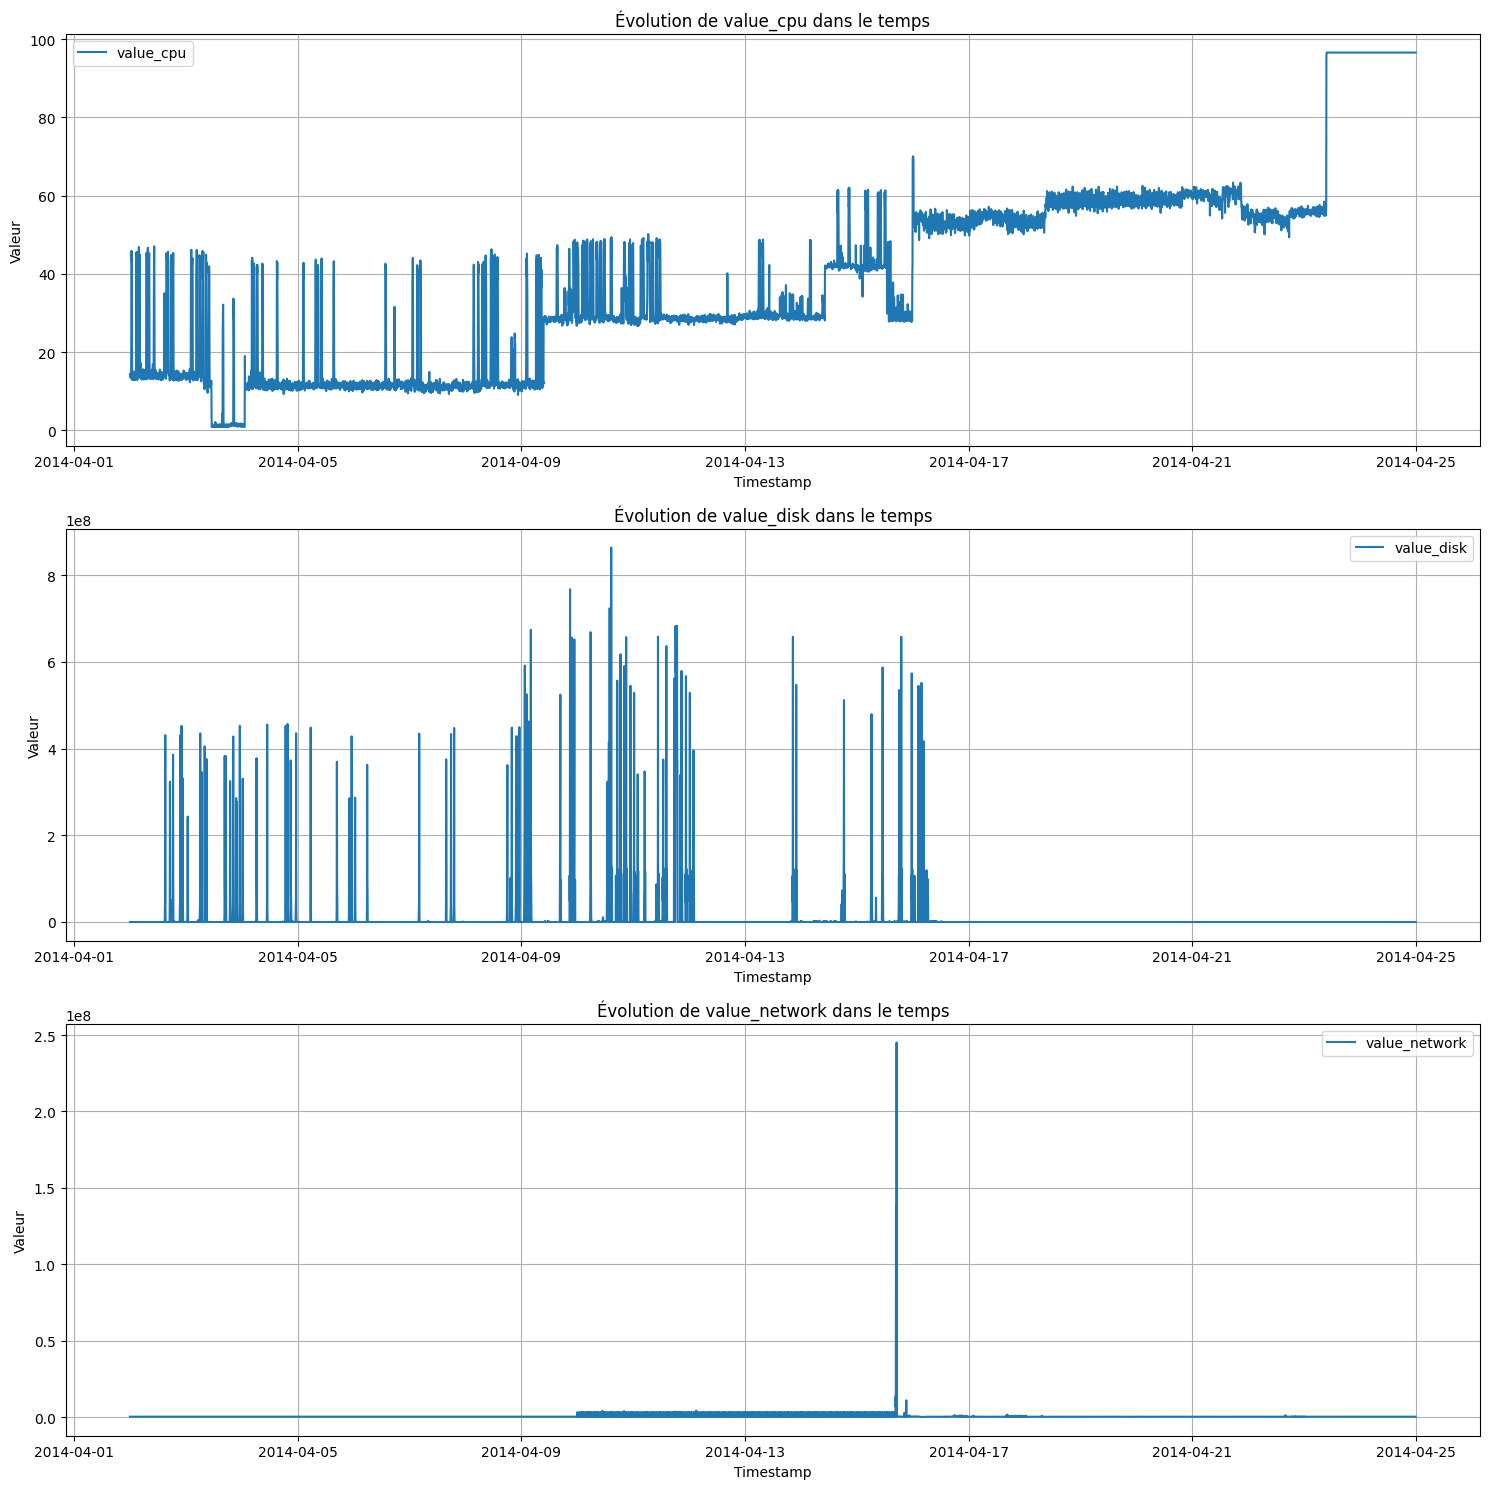

In [11]:
import matplotlib.pyplot as plt

metrics = data_merged.columns[1:-1]  # toutes les colonnes sauf timestamp
n = len(metrics)

plt.figure(figsize=(15, 5 * n))

for i, col in enumerate(metrics, 1):
    plt.subplot(n, 1, i)
    plt.plot(data_merged['timestamp'], data_merged[col], label=col, color='tab:blue')
    plt.title(f"Évolution de {col} dans le temps")
    plt.xlabel("Timestamp")
    plt.ylabel("Valeur")
    plt.grid()
    
    plt.legend()

plt.tight_layout()
plt.show()


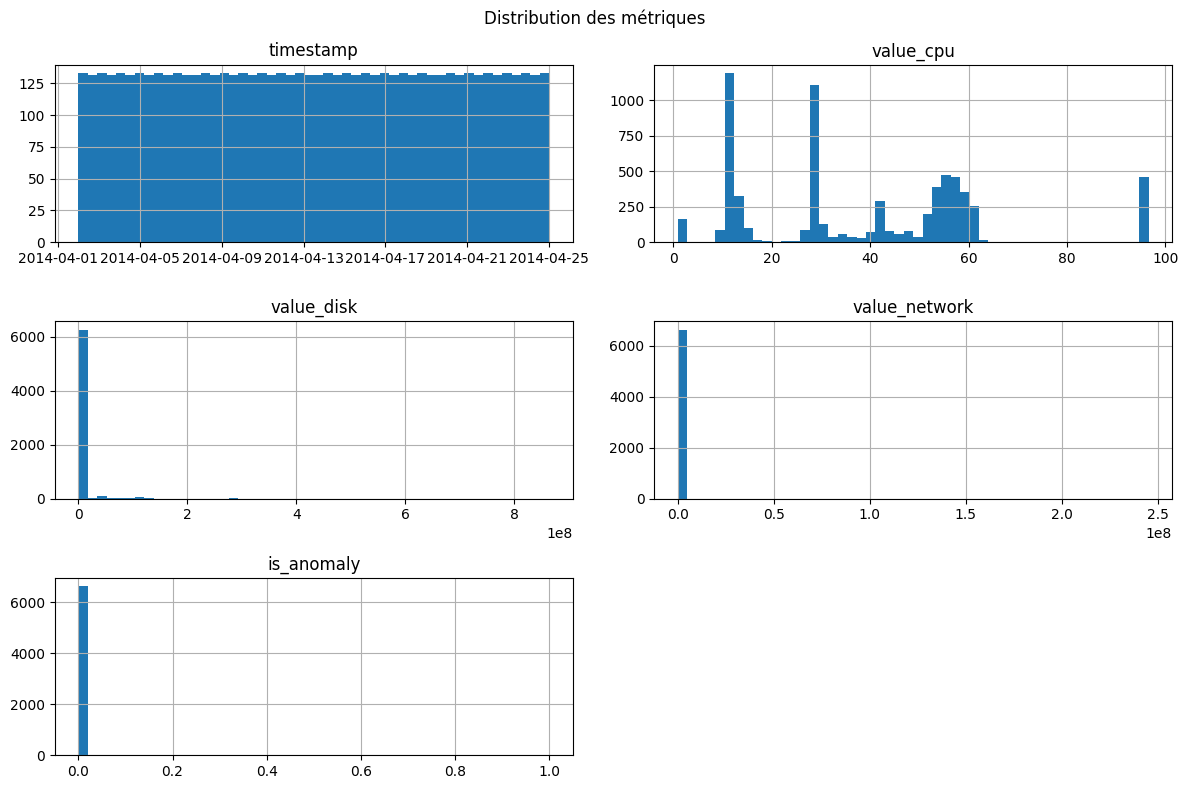

In [12]:
data_merged.hist(figsize=(12, 8), bins=50)
plt.suptitle("Distribution des métriques")
plt.tight_layout()
plt.show()


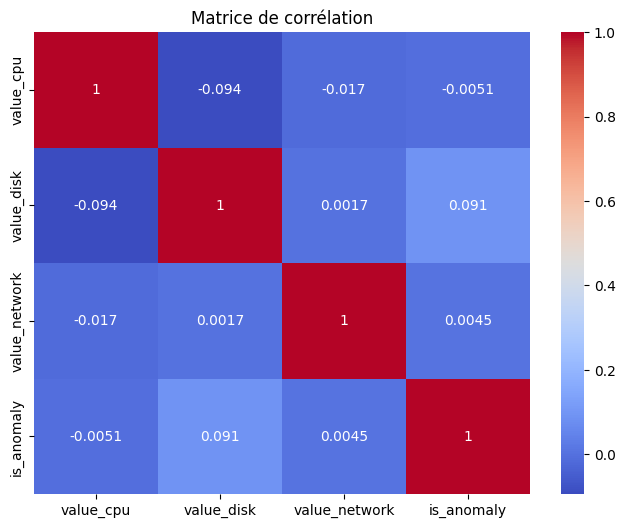

In [13]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(data_merged.drop(columns='timestamp').corr(), annot=True, cmap='coolwarm')
plt.title("Matrice de corrélation")
plt.show()


In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Normaliser uniquement les colonnes numériques (exclure timestamp)
cols_to_scale = ['value_cpu', 'value_disk', 'value_network']

data_merged[cols_to_scale] = scaler.fit_transform(data_merged[cols_to_scale])

print(data_merged.head())


            timestamp  value_cpu  value_disk  value_network  is_anomaly
0 2014-04-02 00:00:00  -1.019779   -0.168136      -0.054067           0
1 2014-04-02 00:05:00  -1.037083   -0.168136      -0.054067           0
2 2014-04-02 00:10:00  -1.008895   -0.168136      -0.054067           0
3 2014-04-02 00:15:00  -1.051357   -0.168136      -0.054067           0
4 2014-04-02 00:20:00  -1.051329   -0.168136      -0.054067           0


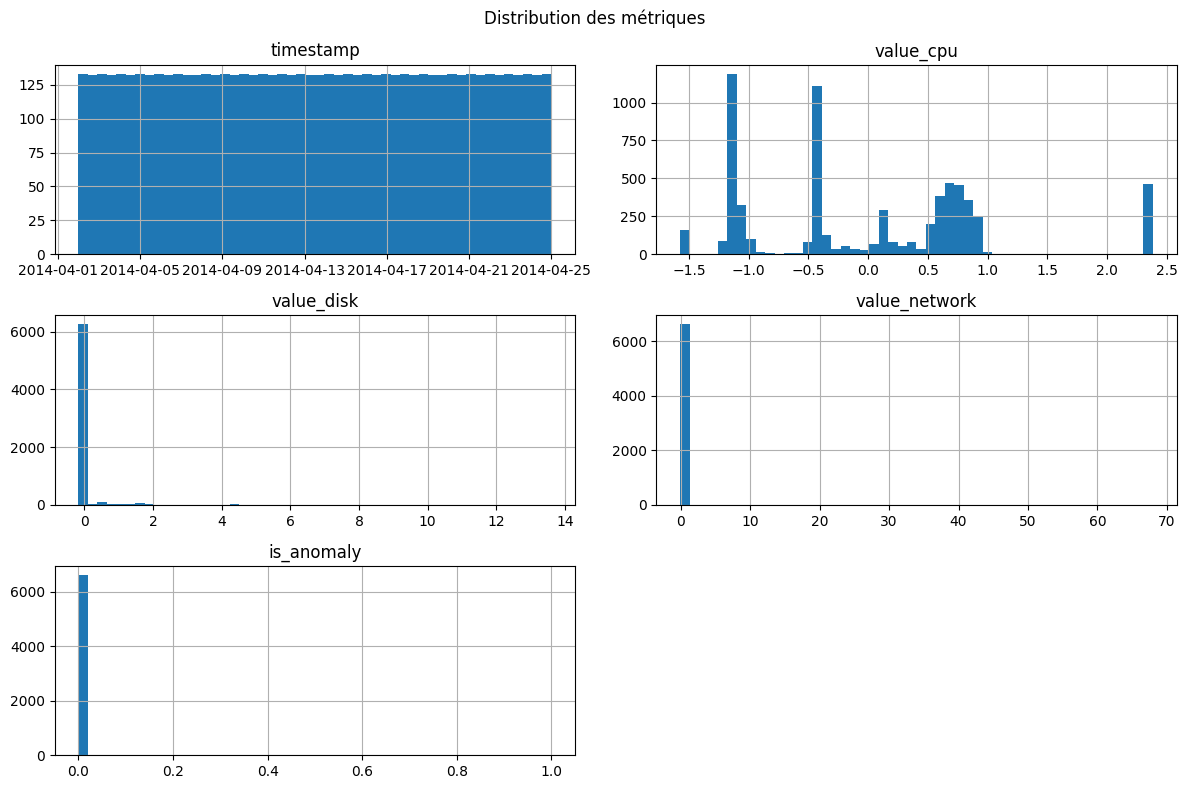

In [15]:
data_merged.hist(figsize=(12, 8), bins=50)
plt.suptitle("Distribution des métriques")
plt.tight_layout()
plt.show()


In [16]:
import json
with open('/kaggle/input/nab-combined-labels/combined_labels.json', 'r') as f:
    labels_dict = json.load(f)

In [21]:
anomalies.values()

dict_values([DatetimeIndex(['2014-04-15 00:50:00'], dtype='datetime64[ns]', freq=None), DatetimeIndex([], dtype='datetime64[ns]', freq=None), DatetimeIndex(['2014-04-09 10:15:00'], dtype='datetime64[ns]', freq=None), DatetimeIndex(['2014-04-15 15:45:00', '2014-04-16 03:35:00'], dtype='datetime64[ns]', freq=None), DatetimeIndex(['2014-04-13 06:50:00', '2014-04-18 23:25:00'], dtype='datetime64[ns]', freq=None), DatetimeIndex(['2014-04-09 01:30:00', '2014-04-10 14:35:00',
               '2014-04-13 03:00:00'],
              dtype='datetime64[ns]', freq=None), DatetimeIndex(['2014-04-15 16:45:00'], dtype='datetime64[ns]', freq=None)])

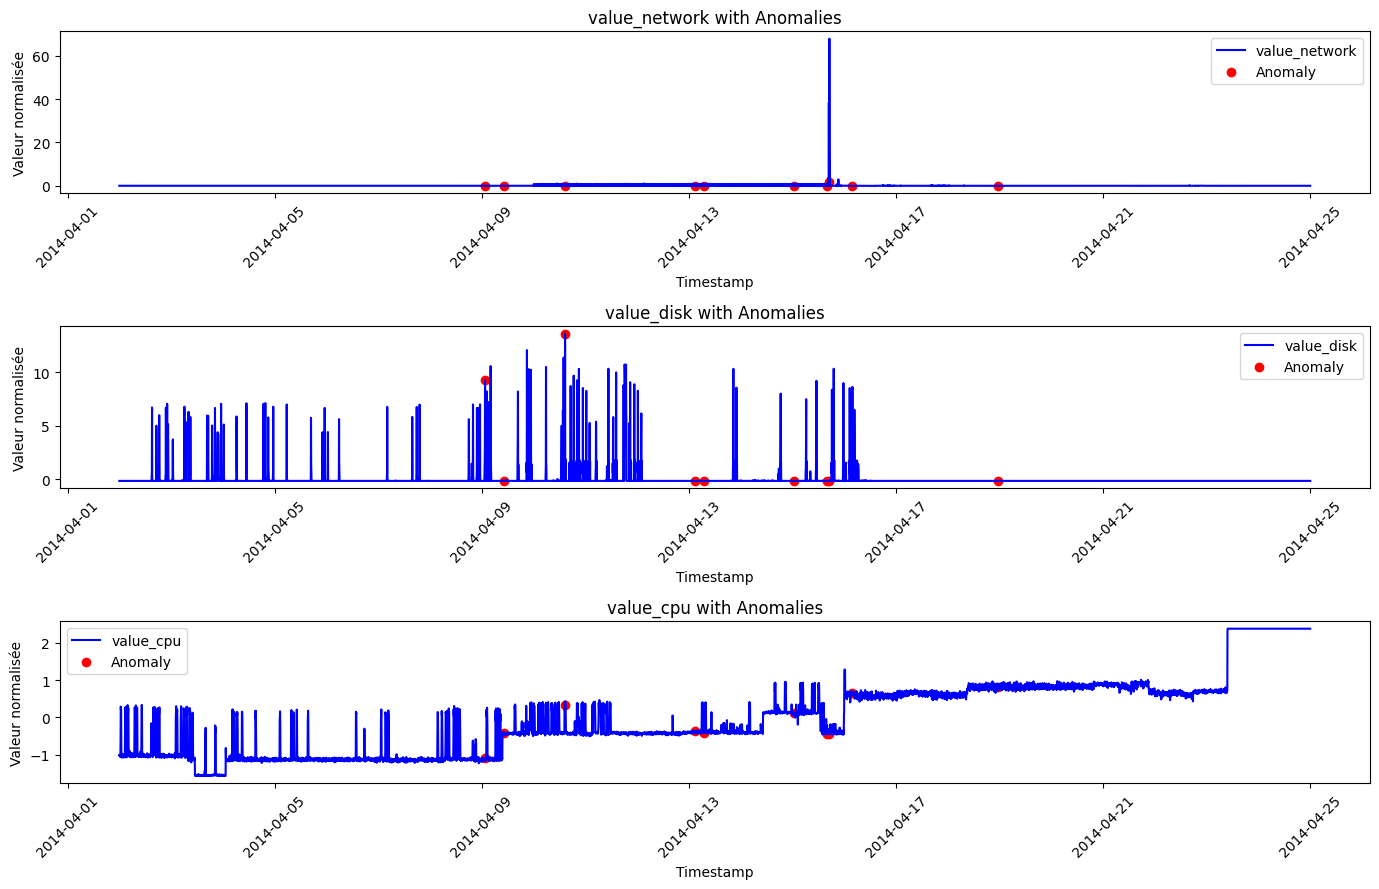

In [22]:
import matplotlib.pyplot as plt

metrics = ['value_network', 'value_disk', 'value_cpu']
n = len(metrics)

plt.figure(figsize=(14, 3 * n))

for i, metric in enumerate(metrics, 1):
    plt.subplot(n, 1, i)
    plt.plot(data_merged['timestamp'], data_merged[metric], label=metric, color='blue')
    plt.scatter(
        data_merged.loc[data_merged['is_anomaly'] == 1, 'timestamp'],
        data_merged.loc[data_merged['is_anomaly'] == 1, metric],
        color='red', label='Anomaly'
    )
    plt.title(f"{metric} with Anomalies")
    plt.xlabel("Timestamp")
    plt.ylabel("Valeur normalisée")
    plt.xticks(rotation=45)
    plt.legend()

plt.tight_layout()
plt.show()


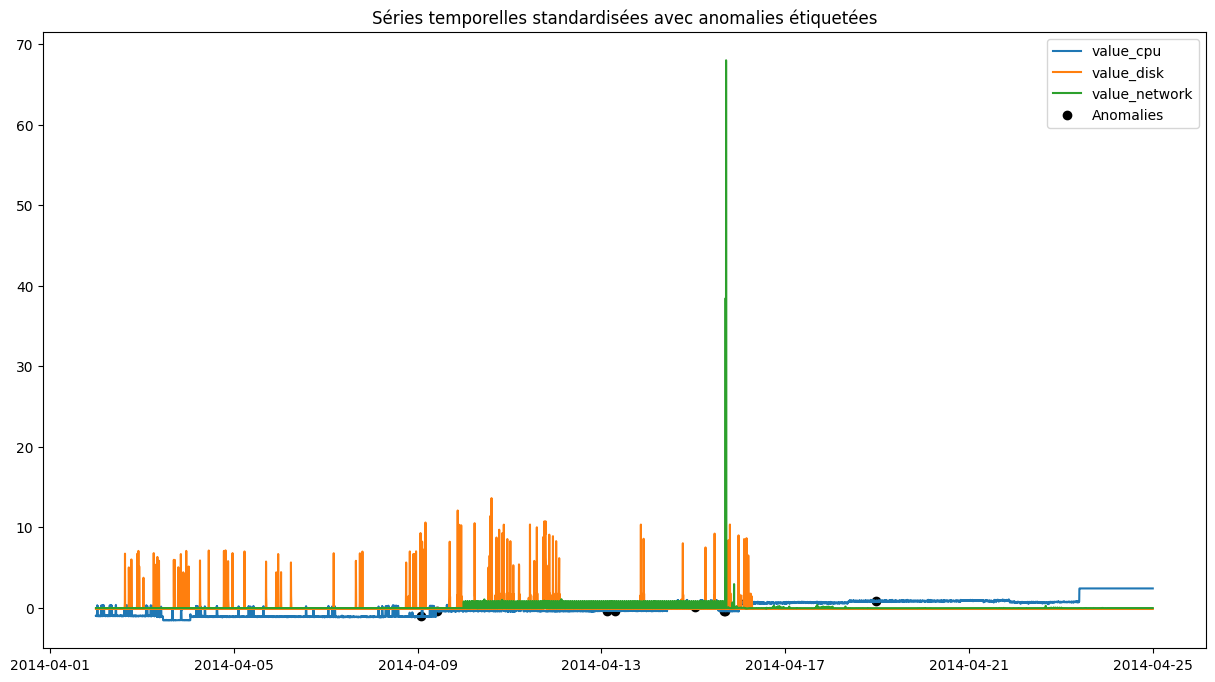

In [26]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 8))
for col in cols_to_scale:
    plt.plot(data_merged['timestamp'], data_merged[col], label=col)
anomalies = data_merged[data_merged['is_anomaly'] == 1]
plt.scatter(anomalies['timestamp'], anomalies[cols_to_scale[0]], c='black', label='Anomalies', marker='o')
plt.legend()
plt.title("Séries temporelles standardisées avec anomalies étiquetées")
plt.show()

# isolation forest

In [31]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix

# 1. Sélectionner les colonnes de features (les métriques)
features = ['value_cpu', 'value_disk', 'value_network']
X = data_merged[features]

# 2. Entraînement du modèle Isolation Forest
model = IsolationForest(contamination=0.02, n_estimators=200, max_samples=256, random_state=42)
model.fit(X)

# 3. Prédictions (-1 = anomaly, 1 = normal)
data_merged['isolation_prediction'] = model.predict(X)
data_merged['isolation_prediction'] = data_merged['isolation_prediction'].map({1: 0, -1: 1})  # Recode: 1=anomaly, 0=normal

# 4. Évaluation avec les vrais labels
print("\nClassification Report:")
print(classification_report(data_merged['is_anomaly'], data_merged['isolation_prediction']))
print("\nConfusion Matrix:")
print(confusion_matrix(data_merged['is_anomaly'], data_merged['isolation_prediction']))


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(



Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      6614
           1       0.02      0.20      0.03        10

    accuracy                           0.98      6624
   macro avg       0.51      0.59      0.51      6624
weighted avg       1.00      0.98      0.99      6624


Confusion Matrix:
[[6483  131]
 [   8    2]]


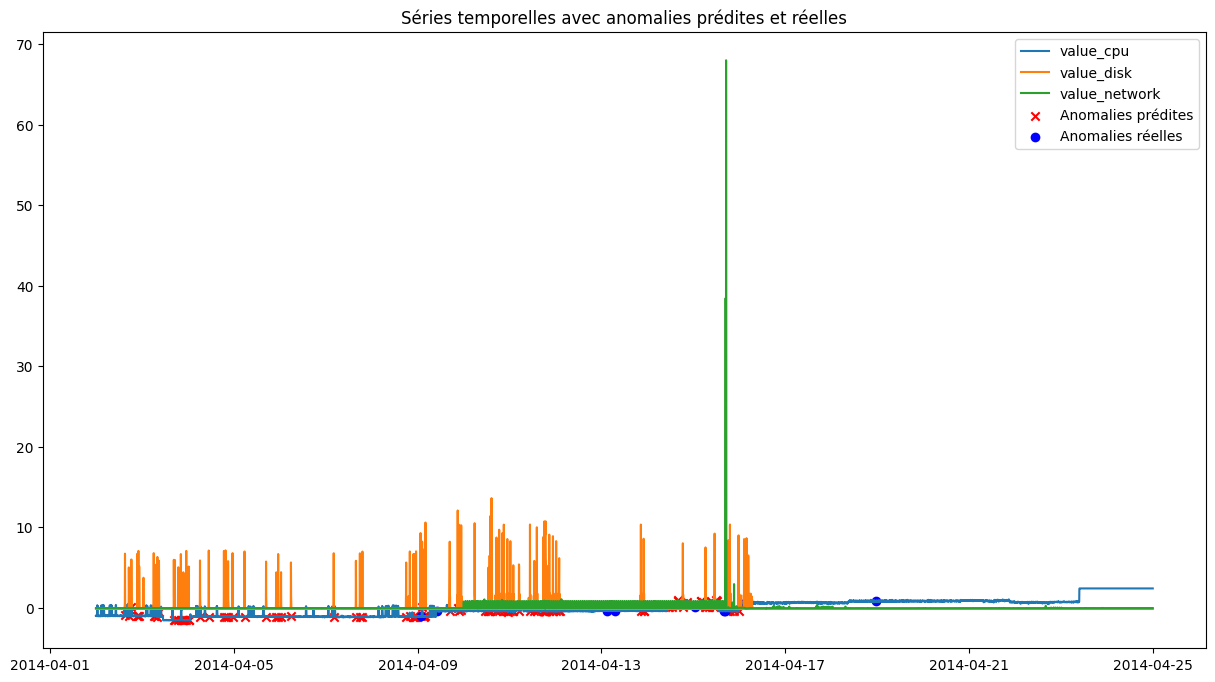

In [32]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 8))
for col in features:
    plt.plot(data_merged['timestamp'], data_merged[col], label=col)
anomalies_pred = data_merged[data_merged['isolation_prediction'] == 1]
anomalies_true = data_merged[data_merged['is_anomaly'] == 1]
plt.scatter(anomalies_pred['timestamp'], anomalies_pred[features[0]], c='red', label='Anomalies prédites', marker='x')
plt.scatter(anomalies_true['timestamp'], anomalies_true[features[0]], c='blue', label='Anomalies réelles', marker='o')
plt.legend()
plt.title("Séries temporelles avec anomalies prédites et réelles")
plt.show()

# One svm

In [34]:
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report, confusion_matrix

# 1. Sélectionner les colonnes de features
X = data_merged[features]

# 2. Entraîner le modèle One-Class SVM
svm = OneClassSVM(kernel='rbf', nu=0.0016, gamma='scale')  # nu = proportion anomalies attendues
svm.fit(X)

# 3. Prédictions
data_merged['svm_anomaly'] = svm.predict(X)
data_merged['svm_anomaly'] = data_merged['svm_anomaly'].map({1: 0, -1: 1})  # 1=anomaly, 0=normal

# 4. Évaluation
print("\nClassification Report (One-Class SVM):")
print(classification_report(data_merged['is_anomaly'], data_merged['svm_anomaly']))
print("\nConfusion Matrix:")
print(confusion_matrix(data_merged['is_anomaly'], data_merged['svm_anomaly']))



Classification Report (One-Class SVM):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6614
           1       0.07      0.10      0.08        10

    accuracy                           1.00      6624
   macro avg       0.54      0.55      0.54      6624
weighted avg       1.00      1.00      1.00      6624


Confusion Matrix:
[[6601   13]
 [   9    1]]


# Kde

In [35]:
from sklearn.neighbors import KernelDensity

X = data_merged[features].values

kde = KernelDensity(kernel='gaussian', bandwidth=0.5)
kde.fit(X)

log_density = kde.score_samples(X)
data_merged['kde_density'] = log_density

threshold = np.percentile(log_density, 6)
data_merged['kde_anomaly'] = (log_density < threshold).astype(int)

# 5. Évaluation
print("\nClassification Report (KDE):")
print(classification_report(data_merged['is_anomaly'], data_merged['kde_anomaly']))
print("\nConfusion Matrix:")
print(confusion_matrix(data_merged['is_anomaly'], data_merged['kde_anomaly']))



Classification Report (KDE):
              precision    recall  f1-score   support

           0       1.00      0.94      0.97      6614
           1       0.01      0.40      0.02        10

    accuracy                           0.94      6624
   macro avg       0.50      0.67      0.49      6624
weighted avg       1.00      0.94      0.97      6624


Confusion Matrix:
[[6223  391]
 [   6    4]]


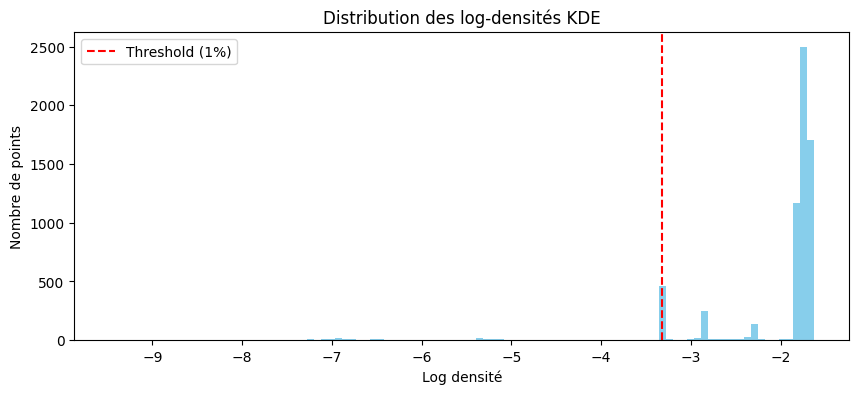

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.hist(log_density, bins=100, color='skyblue')
plt.axvline(threshold, color='red', linestyle='--', label='Threshold (1%)')
plt.title("Distribution des log-densités KDE")
plt.xlabel("Log densité")
plt.ylabel("Nombre de points")
plt.legend()
plt.show()


In [37]:
from sklearn.metrics import classification_report, confusion_matrix

models = {
    'Isolation Forest': 'isolation_prediction',
    'One-Class SVM': 'svm_anomaly',
    'KDE': 'kde_anomaly'
}

for name, col in models.items():
    print(f"\n🔍 {name}")
    print("Classification Report:")
    print(classification_report(data_merged['is_anomaly'], data_merged[col]))
    print("Confusion Matrix:")
    print(confusion_matrix(data_merged['is_anomaly'], data_merged[col]))



🔍 Isolation Forest
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      6614
           1       0.02      0.20      0.03        10

    accuracy                           0.98      6624
   macro avg       0.51      0.59      0.51      6624
weighted avg       1.00      0.98      0.99      6624

Confusion Matrix:
[[6483  131]
 [   8    2]]

🔍 One-Class SVM
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6614
           1       0.07      0.10      0.08        10

    accuracy                           1.00      6624
   macro avg       0.54      0.55      0.54      6624
weighted avg       1.00      1.00      1.00      6624

Confusion Matrix:
[[6601   13]
 [   9    1]]

🔍 KDE
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97      6614
           1       0.01      0.40 

In [38]:
from sklearn.metrics import precision_score, recall_score, f1_score

summary = []

for name, col in models.items():
    precision = precision_score(data_merged['is_anomaly'], data_merged[col])
    recall = recall_score(data_merged['is_anomaly'], data_merged[col])
    f1 = f1_score(data_merged['is_anomaly'], data_merged[col])
    summary.append((name, precision, recall, f1))

# Affichage du résumé
print("\n📊 Résumé des performances :")
print(f"{'Model':<20} {'Precision':<10} {'Recall':<10} {'F1-score':<10}")
for row in summary:
    print(f"{row[0]:<20} {row[1]:<10.3f} {row[2]:<10.3f} {row[3]:<10.3f}")



📊 Résumé des performances :
Model                Precision  Recall     F1-score  
Isolation Forest     0.015      0.200      0.028     
One-Class SVM        0.071      0.100      0.083     
KDE                  0.010      0.400      0.020     


# AE

In [39]:
# Separate normal and anomaly data
features = ['value_cpu', 'value_disk', 'value_network']

normal_data = data_merged[data_merged['is_anomaly'] == 0][features].values
anomaly_data = data_merged[data_merged['is_anomaly'] == 1][features].values

# Split normal data into train and test (e.g., 80% train, 20% test)
X_train, X_normal_test = train_test_split(normal_data, test_size=0.2, random_state=42)

# Keep anomalies for testing
X_anomaly_test = anomaly_data

# Construct X_test by concatenating normal test data and anomalies
X_test = np.concatenate([X_normal_test, X_anomaly_test], axis=0)

# Create y_test: 0 for normal, 1 for anomalies
y_test = np.concatenate([np.zeros(len(X_normal_test)), np.ones(len(X_anomaly_test))], axis=0)

# Verify shapes
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (5291, 3)
X_test shape: (1333, 3)
y_test shape: (1333,)


In [40]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, BatchNormalization, Activation, Input
from tensorflow.keras.optimizers import Adam

timesteps = 10
input_dim = len(features)

def create_sequences(data_array, timesteps):
    sequences = []
    for i in range(len(data_array) - timesteps):
        window = data_array[i:i + timesteps].flatten()
        sequences.append(window)
    return np.array(sequences)

x_train = create_sequences(X_train, timesteps)
x_test = create_sequences(X_test, timesteps)
y_test_seq = y_test[timesteps:]  

In [41]:
def arch(param, data):
    input_shape = data.shape[1]

    input_dots = Input((input_shape,))
    x = Dense(param[0])(input_dots)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Dense(param[1])(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    bottleneck = Dense(param[2], activation='linear')(x)

    x = Dense(param[1])(bottleneck)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Dense(param[0])(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    out = Dense(input_shape, activation='linear')(x)

    model = Model(input_dots, out)
    model.compile(optimizer=Adam(param[3]), loss='mae', metrics=["mse"])
    history = model.fit(
        data, data,
        validation_split=0.2,
        epochs=190,
        batch_size=param[4],
        verbose=1,
        shuffle=True
    )
    return model, history


In [42]:
params = [256, 32, 16, 0.001, 32]
model, history = arch(params, x_train)

Epoch 1/190


2025-07-23 18:54:23.725486: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


132/132 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.5498 - mse: 1.4491 - val_loss: 0.3677 - val_mse: 0.5965
Epoch 2/190
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3291 - mse: 0.7711 - val_loss: 0.2985 - val_mse: 0.4875
Epoch 3/190
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2877 - mse: 0.9132 - val_loss: 0.2491 - val_mse: 0.4381
Epoch 4/190
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2570 - mse: 0.9095 - val_loss: 0.2269 - val_mse: 0.4306
Epoch 5/190
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2367 - mse: 0.9838 - val_loss: 0.1990 - val_mse: 0.4190
Epoch 6/190
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2151 - mse: 0.6914 - val_loss: 0.1878 - val_mse: 0.4170
Epoch 7/190
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2103 - mse: 1.0923 - val_loss: 0.1745 - val_mse: 0.4097
Epoch 8/190
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1981 - mse: 0.8449 - val_loss: 0.1705 - val_mse: 0.4065
Epoch 9/190
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss:

In [43]:
reconstructions = model.predict(x_test)
mse = np.mean(np.square(x_test - reconstructions), axis=1)
threshold = np.percentile(mse[y_test_seq == 0], 99.9)


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [44]:
y_pred = (mse > threshold).astype(int)
print(f"\nSeuil: {threshold:.4f}")
print("Classification Report:")
print(classification_report(y_test_seq, y_pred, digits=4))
print("Confusion Matrix:")
print(confusion_matrix(y_test_seq, y_pred))



Seuil: 4.1273
Classification Report:
              precision    recall  f1-score   support

         0.0     0.9977    0.9985    0.9981      1313
         1.0     0.7778    0.7000    0.7368        10

    accuracy                         0.9962      1323
   macro avg     0.8877    0.8492    0.8675      1323
weighted avg     0.9961    0.9962    0.9961      1323

Confusion Matrix:
[[1311    2]
 [   3    7]]


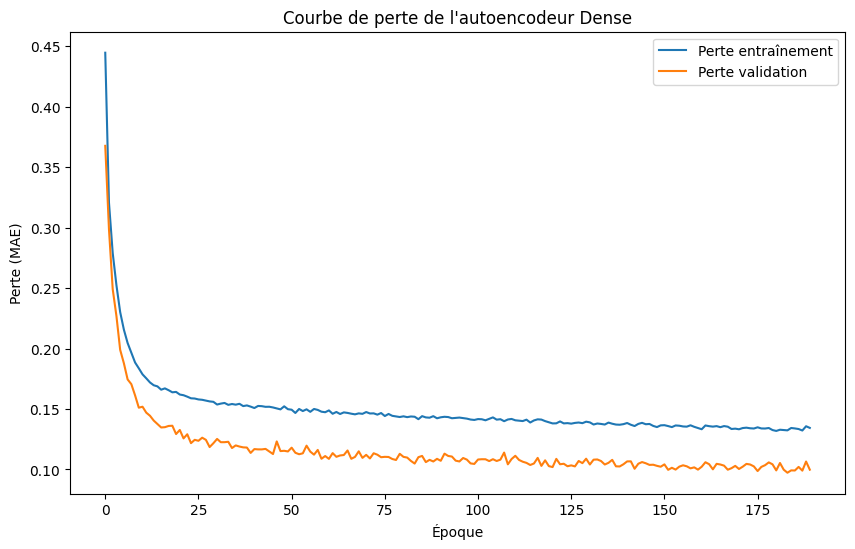

In [45]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Perte entraînement')
plt.plot(history.history['val_loss'], label='Perte validation')
plt.xlabel('Époque')
plt.ylabel('Perte (MAE)')
plt.legend()
plt.title("Courbe de perte de l'autoencodeur Dense")
plt.show()

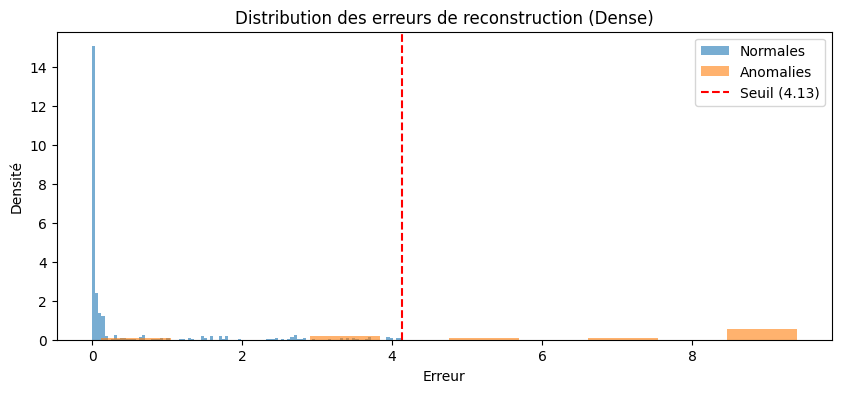

In [48]:
plt.figure(figsize=(10, 4))
plt.hist(mse[y_test_seq == 0], bins=100, alpha=0.6, label="Normales", density=True)
plt.hist(mse[y_test_seq == 1], bins=10, alpha=0.6, label="Anomalies", density=True)
plt.axvline(threshold, color='red', linestyle='--', label=f'Seuil ({threshold:.2f})')
plt.title("Distribution des erreurs de reconstruction (Dense)")
plt.xlabel("Erreur")
plt.ylabel("Densité")
plt.legend()
plt.show()

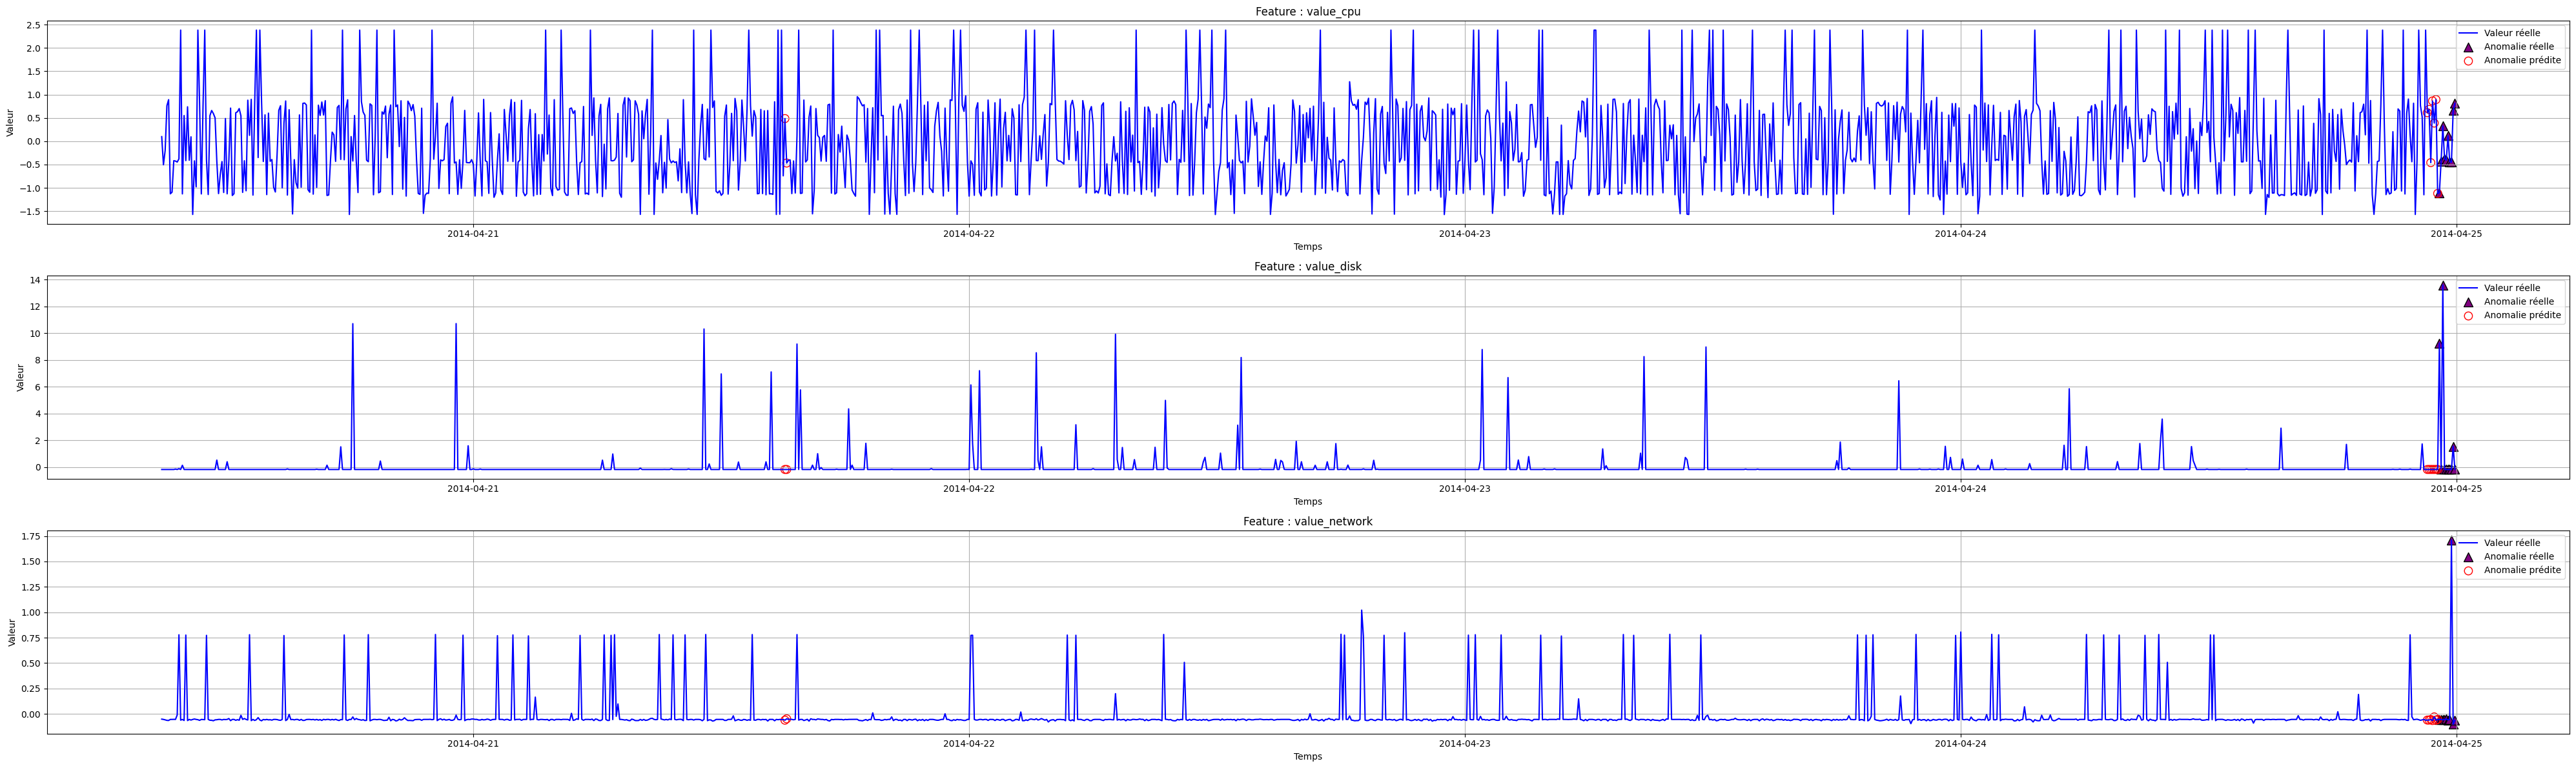

In [49]:
import matplotlib.pyplot as plt
import numpy as np

timestamps = data_merged.iloc[-len(X_test):]['timestamp'].values
n_features = X_test.shape[1]

plt.figure(figsize=(40, 4 * n_features))

for i in range(n_features):
    plt.subplot(n_features, 1, i + 1)
    
    # Série temporelle
    plt.plot(timestamps, X_test[:, i], color='blue', label='Valeur réelle')

    # Vraies anomalies - triangles violets plus grands et bordés
    true_anomalies_idx = np.where(y_test == 1)[0]
    plt.scatter(timestamps[true_anomalies_idx],
                X_test[true_anomalies_idx, i],
                color='purple',
                edgecolors='black',
                marker='^',
                s=100,
                label='Anomalie réelle')

    # Anomalies prédites - cercles rouges vides
    pred_anomalies_idx = np.where(y_pred == 1)[0]
    plt.scatter(timestamps[pred_anomalies_idx],
                X_test[pred_anomalies_idx, i],
                edgecolors='red',
                facecolors='none',
                marker='o',
                s=80,
                label='Anomalie prédite')

    plt.title(f"Feature : {features[i]}")
    plt.xlabel("Temps")
    plt.ylabel("Valeur")
    plt.legend(loc='upper right')
    plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
model.save('autoencodeur.h5')

# Sauvegarde des seuils + paramètres éventuels
config = {
    "threshold": threshold,
    "params": params
}

with open("model_config.json", "w") as f:
    json.dump(config, f)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


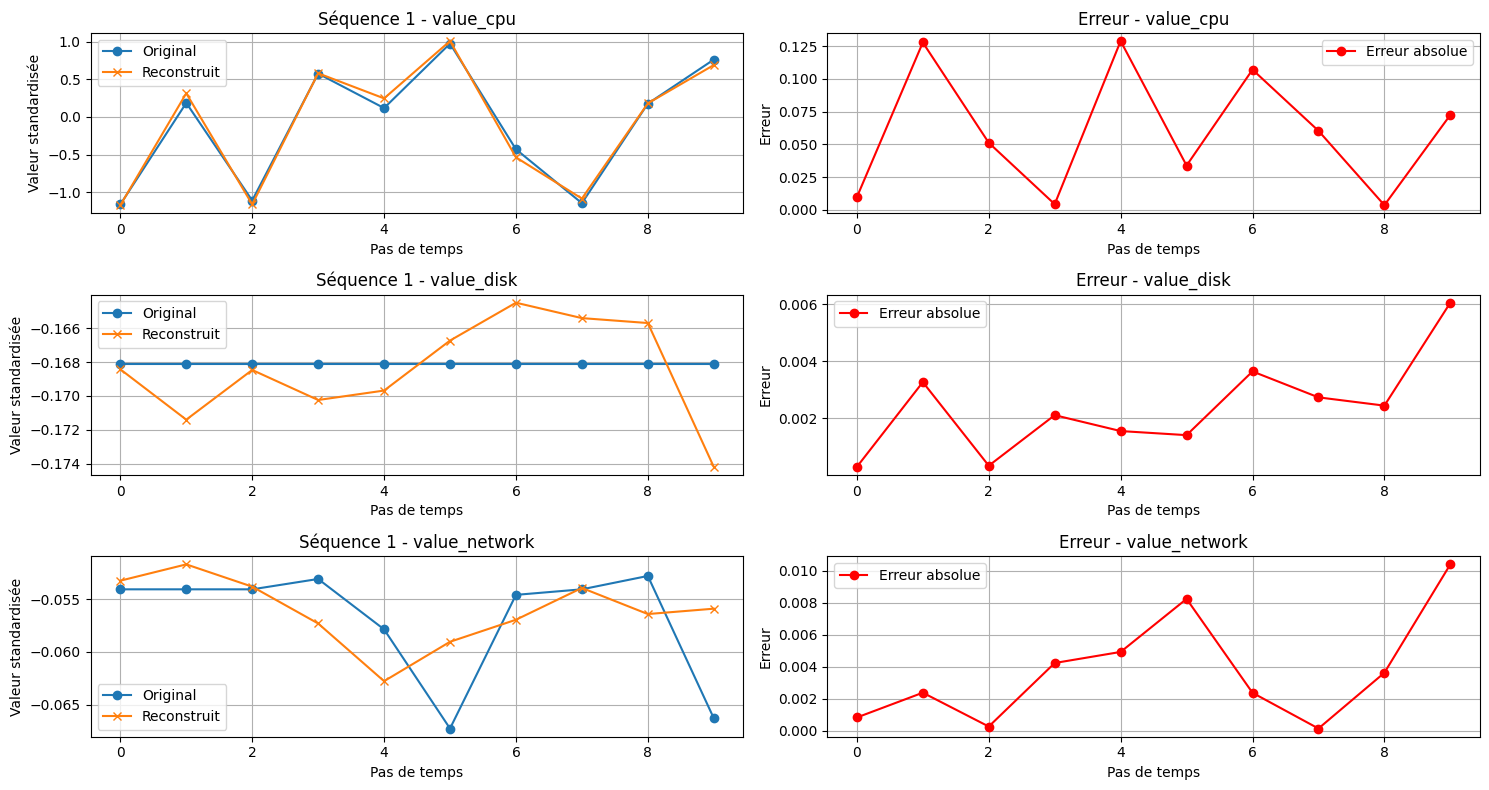

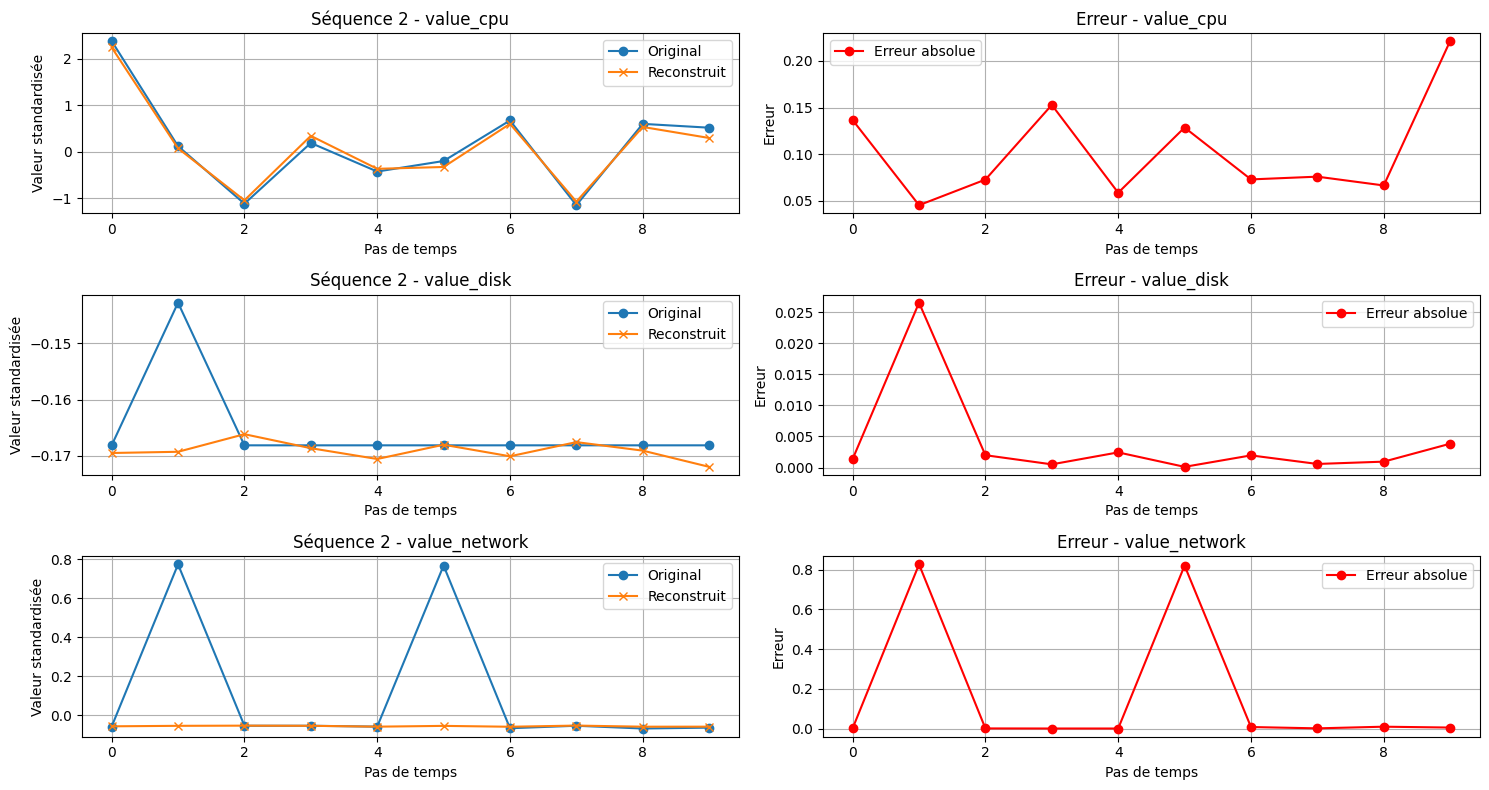

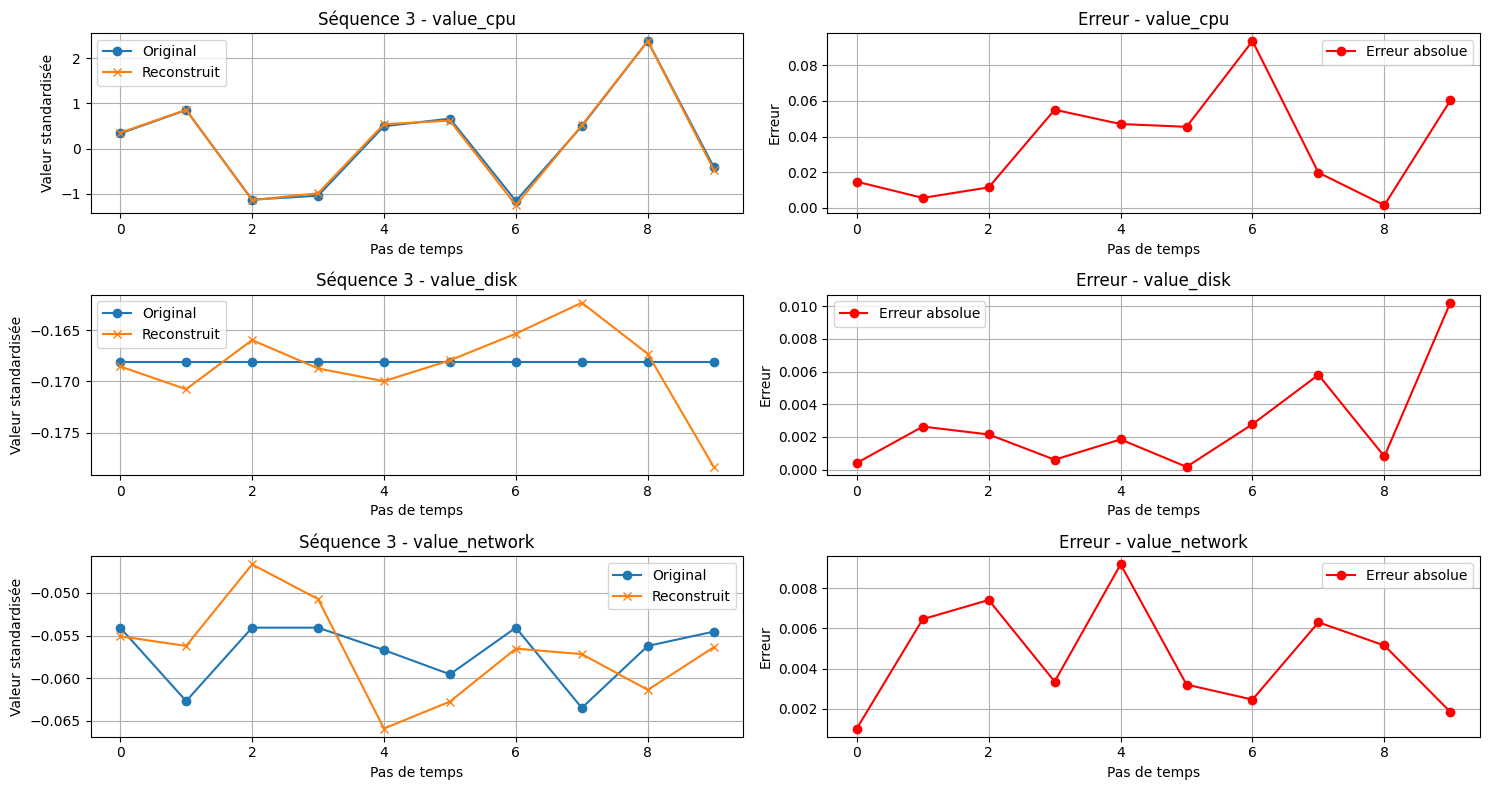

Erreur MSE pour la séquence 1 : 0.001914
Erreur MSE pour la séquence 2 : 0.049740
Erreur MSE pour la séquence 3 : 0.000696


In [51]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Paramètres
n_sequences = 3         # Nombre de séquences à visualiser
timesteps = 10          # Taille d'une séquence
n_features = len(features)

# 2. Sélectionner des séquences aléatoires depuis x_train (données aplaties)
indices = np.random.choice(len(x_train), n_sequences, replace=False)
X_sample = x_train[indices]  # (n_sequences, timesteps * n_features)

# 3. Prédire les reconstructions
reconstructions = model.predict(X_sample)  # même forme que X_sample

# 4. Reshape pour visualisation (de (n, 30) → (n, 10, 3))
X_sample_reshaped = X_sample.reshape((n_sequences, timesteps, n_features))
reconstructions_reshaped = reconstructions.reshape((n_sequences, timesteps, n_features))

# 5. Visualisation
for i in range(n_sequences):
    plt.figure(figsize=(15, 8))
    
    for j, feature in enumerate(features):
        # Original vs Reconstruit
        plt.subplot(len(features), 2, 2*j + 1)
        plt.plot(X_sample_reshaped[i, :, j], label='Original', marker='o')
        plt.plot(reconstructions_reshaped[i, :, j], label='Reconstruit', marker='x')
        plt.title(f"Séquence {i+1} - {feature}")
        plt.xlabel("Pas de temps")
        plt.ylabel("Valeur standardisée")
        plt.legend()
        plt.grid(True)

        # Erreur absolue
        plt.subplot(len(features), 2, 2*j + 2)
        error = np.abs(X_sample_reshaped[i, :, j] - reconstructions_reshaped[i, :, j])
        plt.plot(error, label='Erreur absolue', marker='o', color='red')
        plt.title(f"Erreur - {feature}")
        plt.xlabel("Pas de temps")
        plt.ylabel("Erreur")
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

# 6. Calculer et afficher l'erreur MSE par séquence
mse = np.mean(np.power(X_sample - reconstructions, 2), axis=1)
for i in range(n_sequences):
    print(f"Erreur MSE pour la séquence {i+1} : {mse[i]:.6f}")
